In [7]:
#import the batch1 batch2 data with zscores and raw clinical scores
#will use only the z-scores for analysis here
#will do the binning here

import pandas as pd
columns_to_drop=['ID', 'Batch','PAM50', 'Subtype', 'HR_status', 'HER_status', 
                 'Age','AgeGroup', 'Stage', 'TumorGrade', 'TumourSize']
rename_dict={'PAM50.1':'PAM50', 'Subtype.1':'Subtype', 'HR_status.1':'HR_status', 
                 'HER_status.1':'HER2_status', 'Age.1':'Age', 'AgeGroup.1':'AgeGroup', 
                 'Stage.1':'Stage', 'TumorGrade.1':'TumourGrade', 'TumourSize.1':'TumourSize',}
df_b1 = pd.read_csv('data_batch1_cleanedV2.tsv', delimiter='\t').drop(columns=columns_to_drop).rename(columns=rename_dict)
df_b2 = pd.read_csv('data_batch2_cleanedV2.tsv', delimiter='\t').drop(columns=columns_to_drop).rename(columns=rename_dict)

In [8]:
#define immune scores in a list
immune_scores=list(df_b1.columns[17:])
x_variables=['HR_status', 'HER2_status', 'Age','Stage', 'TumourGrade', 
             'TumourSize', 'FusionNeo_Count','SNVindelNeo_Count']

In [21]:
#test lasso regression using the ztransformed continuous data first. we will test using bins after this
#essentially a comparison of continuous VS discrete - for impact on model performance

Executing lasso_functino() for batch 1...


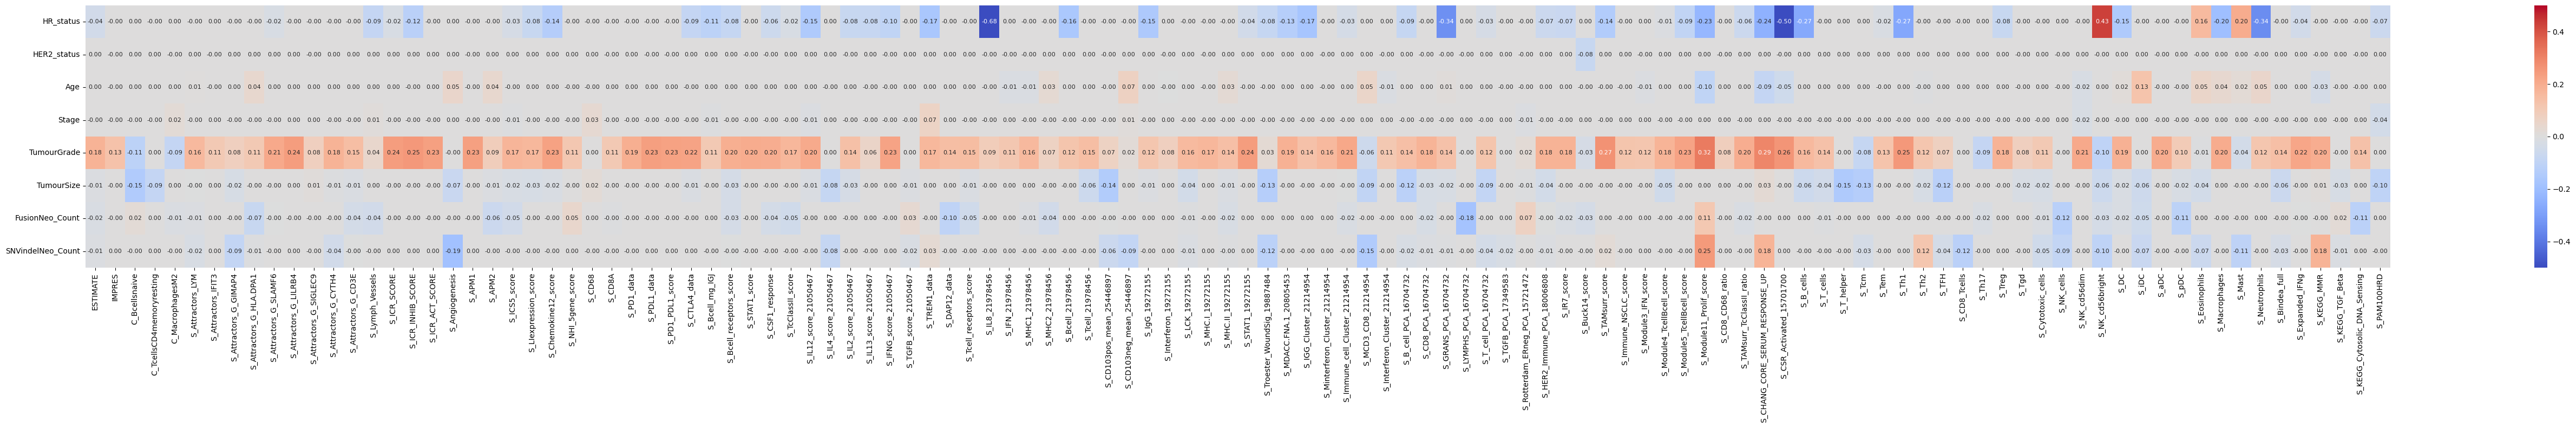

Executing lasso_functino() for batch 2...


<Figure size 640x480 with 0 Axes>

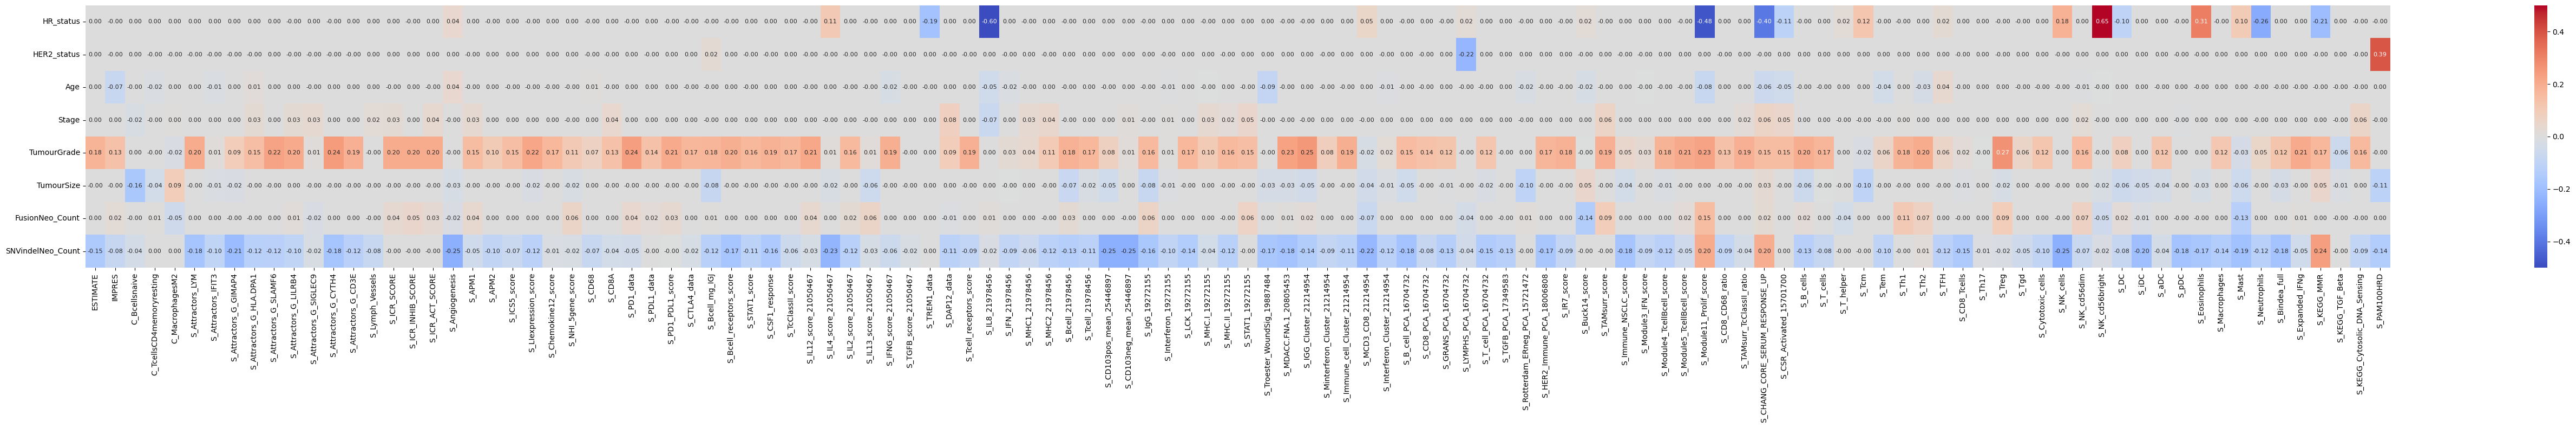

<Figure size 640x480 with 0 Axes>

In [11]:
#from previous testing - we decided to only stick with alpha=0.1
#perform this for batch1 first

def lasso_function(df,batch):
    print (f'Executing lasso_function() for batch {batch}... using alpha={alphas}')
    #define the independent variables for regression
    X = df[x_variables]

    # ROUND1: Selecting predictor and response variables
    mses={}
    coefs={}
    y_preds={}
    y_tests={}


    #alphas=[0.01, 0.0325, 0.055, 0.0775, 0.1]
    #alphas_dict={0.01:"0.01", 0.0325:"0.0325", 0.055:"0.055", 0.0775:"0.0775", 0.1:"0.1"}
    #alphas=[0.08,0.1]
    #alphas_dict={0.08:"0.08",0.1:"0.1"}
    alphas=[0.08]
    alphas_dict={0.08:"0.08"}

    from sklearn.linear_model import Lasso
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    
    for score in immune_scores:
        y = df[score]  # dependent variable

        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        for alpha_value in alphas:
            # Create a Lasso regression model
            lasso = Lasso(alpha=alpha_value)  # alpha is the regularization parameter

            # Fit the model to the training data
            lasso.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = lasso.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)

            #saving the values for comparision in a table later
            num=alphas_dict[alpha_value]
            mses[f'{score}']=mse
            coefs[f'{score}']=lasso.coef_
            y_preds[f'{score}']=y_pred
            y_tests[f'{score}']=y_test

    coef_output=pd.DataFrame(coefs, index=list(X.columns))
#     print (coef_output)
    
#     # visualise the coef across all 116 IS using heatmap!
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Assuming 'df' is your DataFrame
    # Create the heatmap
    plt.figure(figsize=(55,8))  # Adjust the size of the figure as needed
    sns.heatmap(coef_output, cmap='coolwarm', center=0, vmin=-0.5, vmax=0.5, annot=True, annot_kws={"size": 8},fmt=".2f")

    # Display the heatmap
    plt.tight_layout()
    plt.savefig(f'lassoV2_a008_batch{batch}.png',dpi=600)
    plt.show()
    plt.clf()

lasso_function(df_b1,1)
lasso_function(df_b2,2)

In [ ]:
#seems like fusion/snv 

In [ ]:
#yjz transformation is done! now i create IS and neo count bins before exporting

# def categorize_by_tertile(data):
#     q1, q2 = data.quantile([1/3, 2/3])  # Calculate first and third tertiles
#     categories = pd.cut(data, [float('-inf'), q1, q2, float('inf')], labels=[1, 2, 3])
#     return categories

# neos=['FusionNeo_Count','SNVindelNeo_Count']
# df_NeoBins = pd.DataFrame()
# for neo in neos:
#     df_NeoBins[[neo]] = df1_yjz_merge[[neo]].apply(categorize_by_tertile)
    
    
##round 2 - neocount bin only 1/2
def categorize_by_median(data):
    q1 = data.quantile(0.5)  # Calculate first and third tertiles
    categories = pd.cut(data, [float('-inf'), q1, float('inf')], labels=[1, 2])
    return categories

neos=['FusionNeo_Count','SNVindelNeo_Count']
df_NeoBins = pd.DataFrame()
for neo in neos:
    df_NeoBins[[neo]] = df1_yjz_merge[[neo]].apply(categorize_by_median)

    
df_NeoBins.columns=['bin_FusionNeo_Count','bin_SNVindelNeo_Count']
#combined the raw scores with neo bin for exporting

df_export=pd.concat([df['Batch'],df_NeoBins,df1_yjz_merge],axis=1)
df_export.to_csv("data_updated230524_new_excludedIHC_excludedNaN_processedV2.tsv", sep="\t", index=False)